In [1]:
import config

from tqdm import tqdm
import warnings
import os
from hyena_dna.standalone_hyenadna import HyenaDNAModel
import torch
import pickle
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier


os.environ['PYTHONWARNINGS'] = 'ignore'
warnings.filterwarnings('ignore')
os.chdir(config.DIR_ROOT)

/Users/nad/miniconda3/envs/mobiraph1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scripts.n10_classification_table_nice import plot_classification_report

In [3]:
%config InlineBackend.figure_format = 'retina'

# Logistic Regression

In [48]:
name_to_embedding = {}
name_to_type = {}
path_to_hyena_embedding = os.path.join(config.DIR_INCEST_MANY, 'hyena_embeddings_and_types.pkl')
with open(path_to_hyena_embedding, "rb") as f:
    data = pickle.load(f)


name_to_embedding = data['embeddings']
name_to_type = data['types']


path_to_filtered = os.path.join(config.DIR_INCEST_MANY, 'repbase_filtered.csv')
df_filtered = pd.read_csv(path_to_filtered)
names = list(df_filtered['name'])


X = np.array([name_to_embedding[name] for name in names])
y = np.array([name_to_type[name] for name in names])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=1,
    stratify=y
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

param_grid = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "solver": ["lbfgs"],
    "penalty": ["l2"],
    "multi_class": ["auto"],
    "class_weight": ["balanced"]
}

scoring = {
    "accuracy": "accuracy",
    "f1_macro": make_scorer(f1_score, average="macro")
}

gs = GridSearchCV(
    estimator=LogisticRegression(max_iter=2000),
    param_grid=param_grid,
    scoring=scoring,
    refit="f1_macro",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    verbose=0
)

gs.fit(X_train, y_train)

print("Лучшие параметры:", gs.best_params_)
print("Лучшая CV F1-macro:", gs.best_score_)

best_model = gs.best_estimator_

Лучшие параметры: {'C': 10.0, 'class_weight': 'balanced', 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
Лучшая CV F1-macro: 0.8120265746111812


In [61]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
class_names = sorted(list(set(y_test) | set(y_pred)))
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plot_classification_report(y_test, y_pred, title='Classification Report для Logistic Regression на Hyena')

array(['Non-LTR retrotransposon'], dtype='<U23')

In [65]:
# восстановим индексы тестовой выборки тем же split'ом
idx = np.arange(len(y))
_, test_idx = train_test_split(idx, test_size=0.2, random_state=1, stratify=y)
names_test = np.array(names)[test_idx]

# напечатаем по одному корректному примеру на класс
y_pred = best_model.predict(X_test)
correct = (y_test == y_pred)
for cls in class_names:
    i = np.where((y_test == cls) & correct)[0]
    print(f"{cls}: {names_test[i[0]] if i.size else 'нет корректных'}")

DNA transposon: Helitron-N2C_CGi_Helitron_Crassostrea_gigas
LTR retrotransposon: ATCOPIA97I_Copia_Arabidopsis_thaliana
Non-LTR retrotransposon: L1-9_LCh_L1_Latimeria_chalumnae


Accuracy: 0.800990916597853


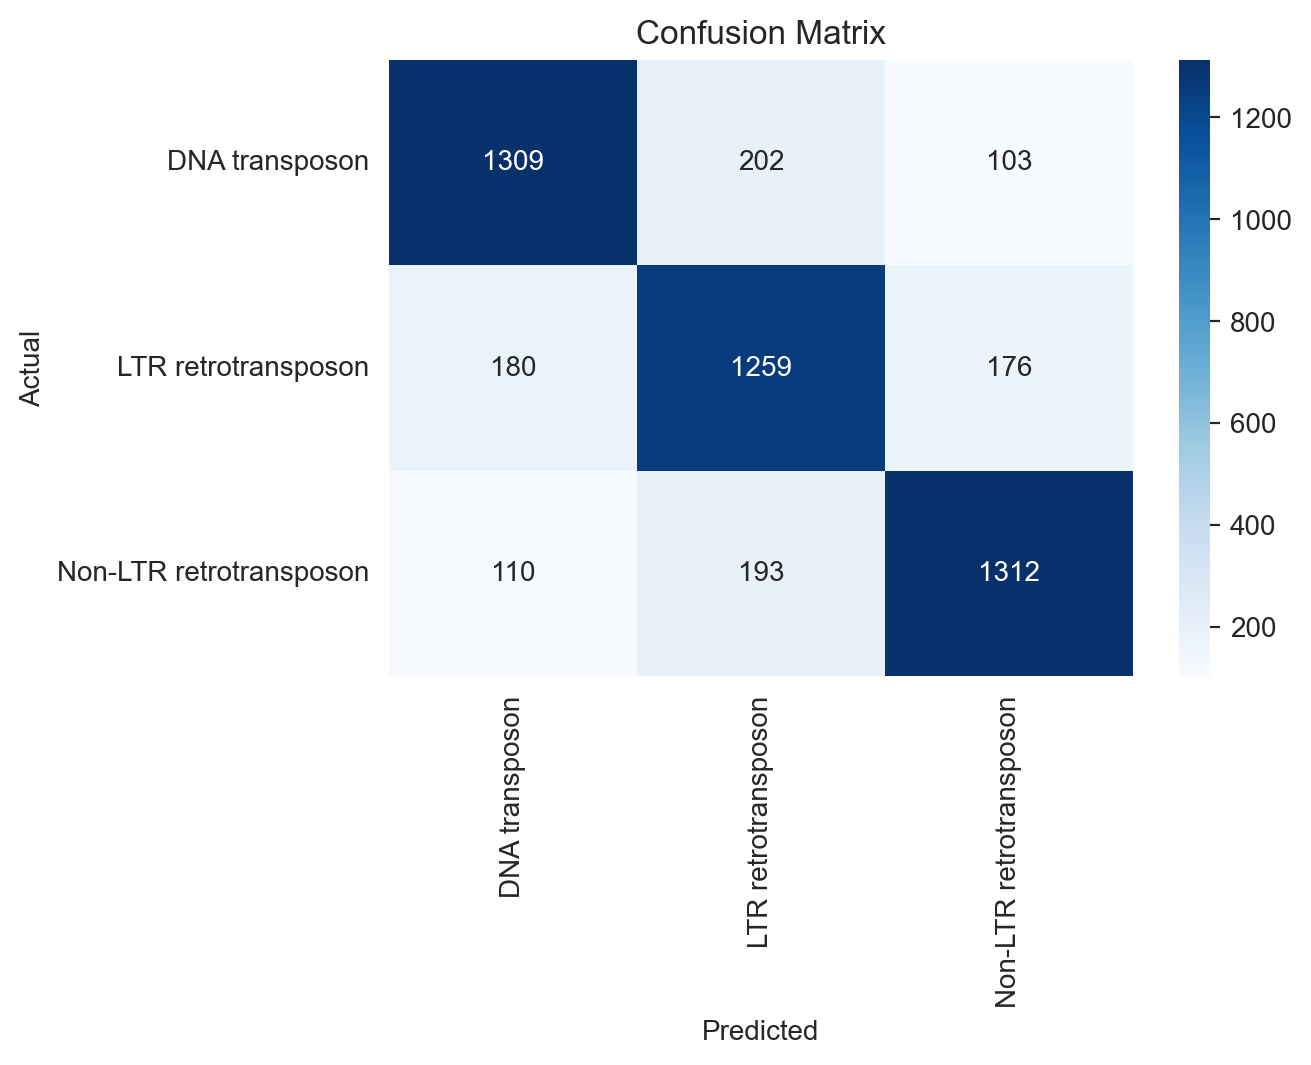

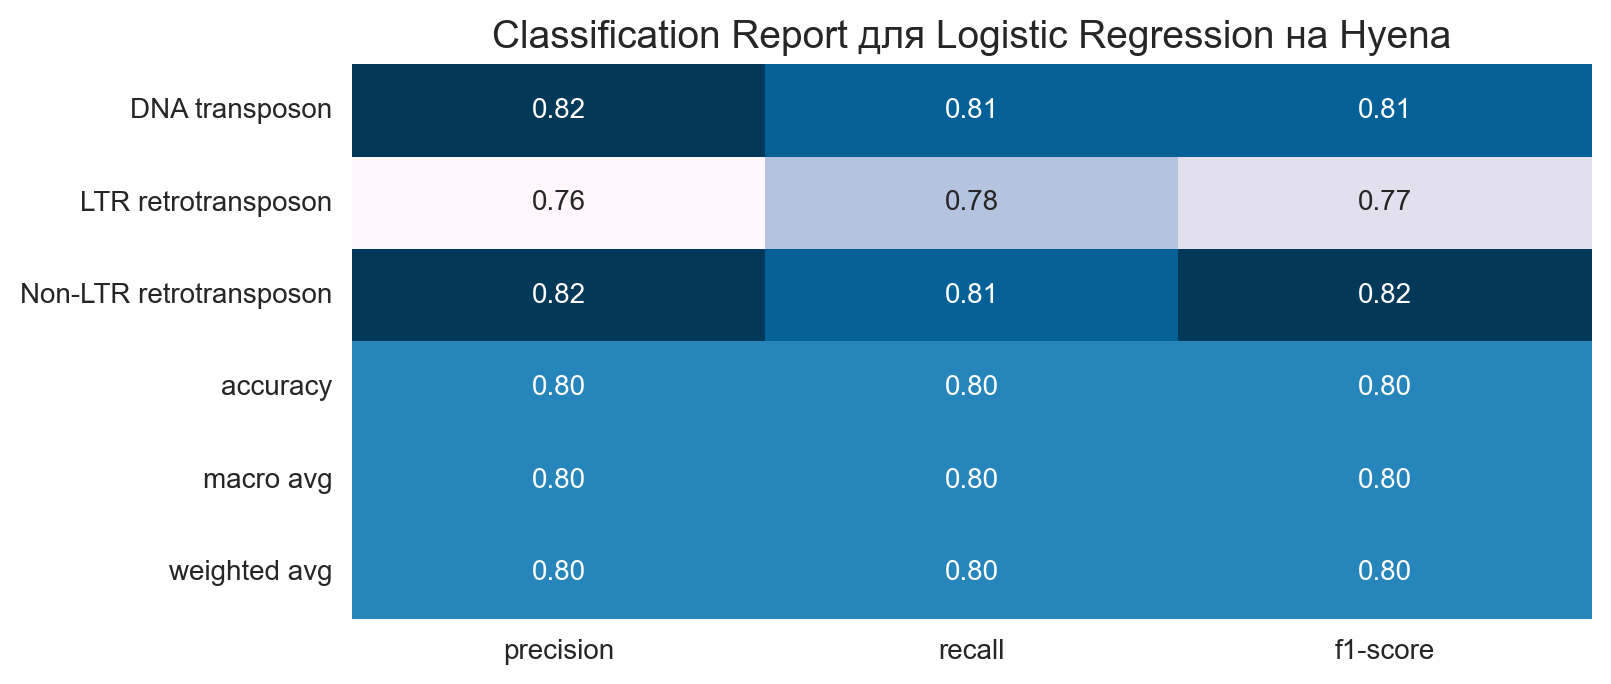

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

param_grid = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "kernel": ["linear", "rbf"],
    "class_weight": ["balanced"]
}

scoring = {
    "accuracy": "accuracy",
    "f1_macro": make_scorer(f1_score, average="macro")
}

gs = GridSearchCV(
    estimator=SVC(max_iter=1000),
    param_grid=param_grid,
    scoring=scoring,
    refit="f1_macro",
    cv=cv,
    n_jobs=-1,
    return_train_score=False,
    verbose=0
)

gs.fit(X_train, y_train)

print("Лучшие параметры:", gs.best_params_)
print("Лучшая CV F1-macro:", gs.best_score_)

best_model = gs.best_estimator_

In [60]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
class_names = sorted(list(set(y_test) | set(y_pred)))
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plot_classification_report(y_test, y_pred, title='Classification Report для SVM на Hyena')

DNA transposon: Helitron-N2C_CGi_Helitron_Crassostrea_gigas
LTR retrotransposon: ATCOPIA97I_Copia_Arabidopsis_thaliana
Non-LTR retrotransposon: L1-9_LCh_L1_Latimeria_chalumnae


In [19]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
class_names = sorted(list(set(y_test) | set(y_pred)))
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plot_classification_report(y_test, y_pred)

Лучшие параметры: {'C': 10.0, 'class_weight': 'balanced', 'kernel': 'rbf'}
Лучшая CV F1-macro: 0.6265329596200304


Accuracy: 0.4727497935590421


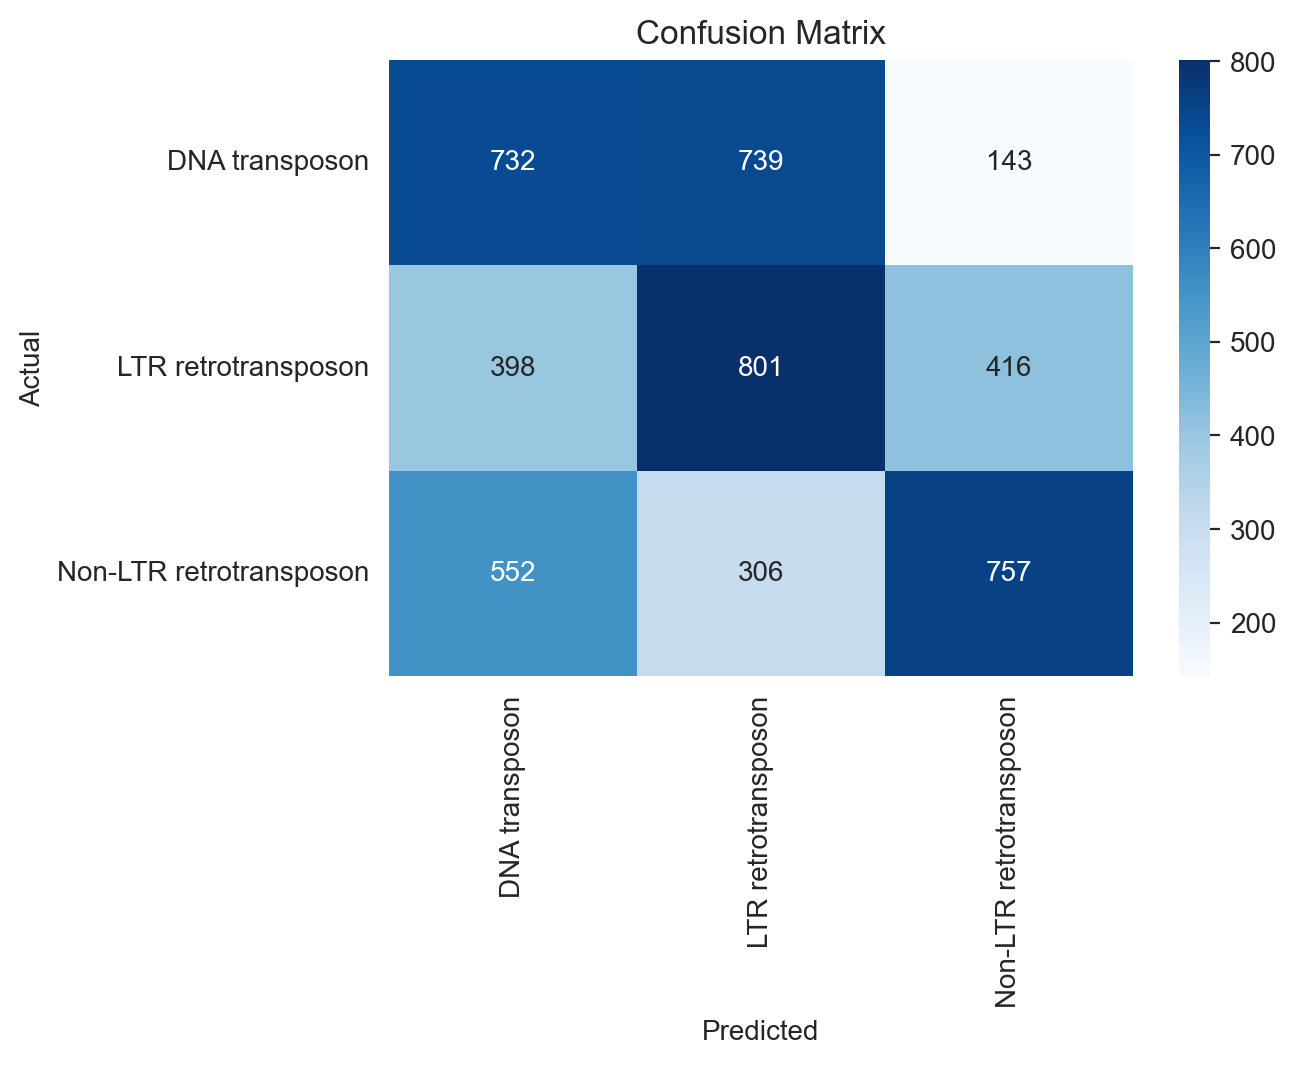

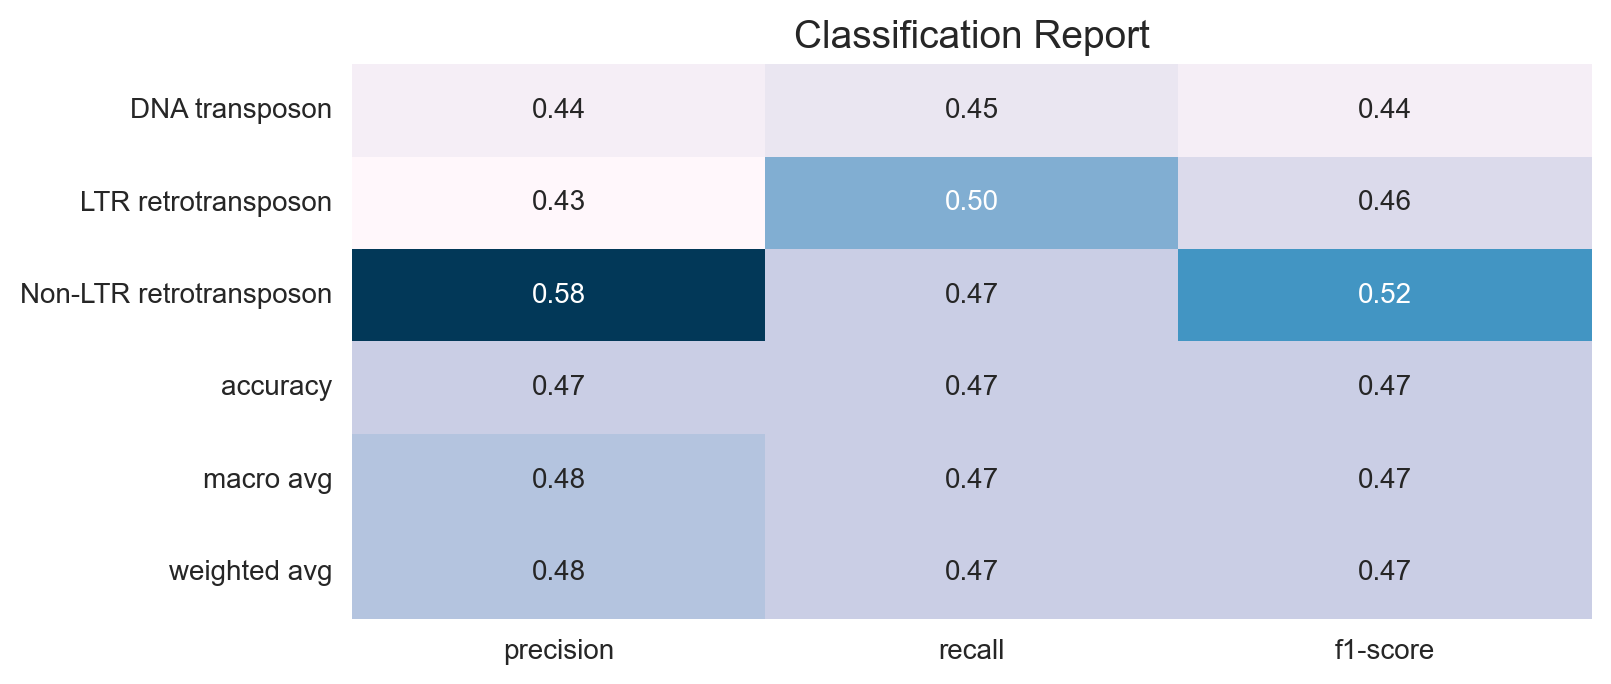

In [20]:
print(classification_report(y_test, y_pred))

Accuracy: 0.4727497935590421


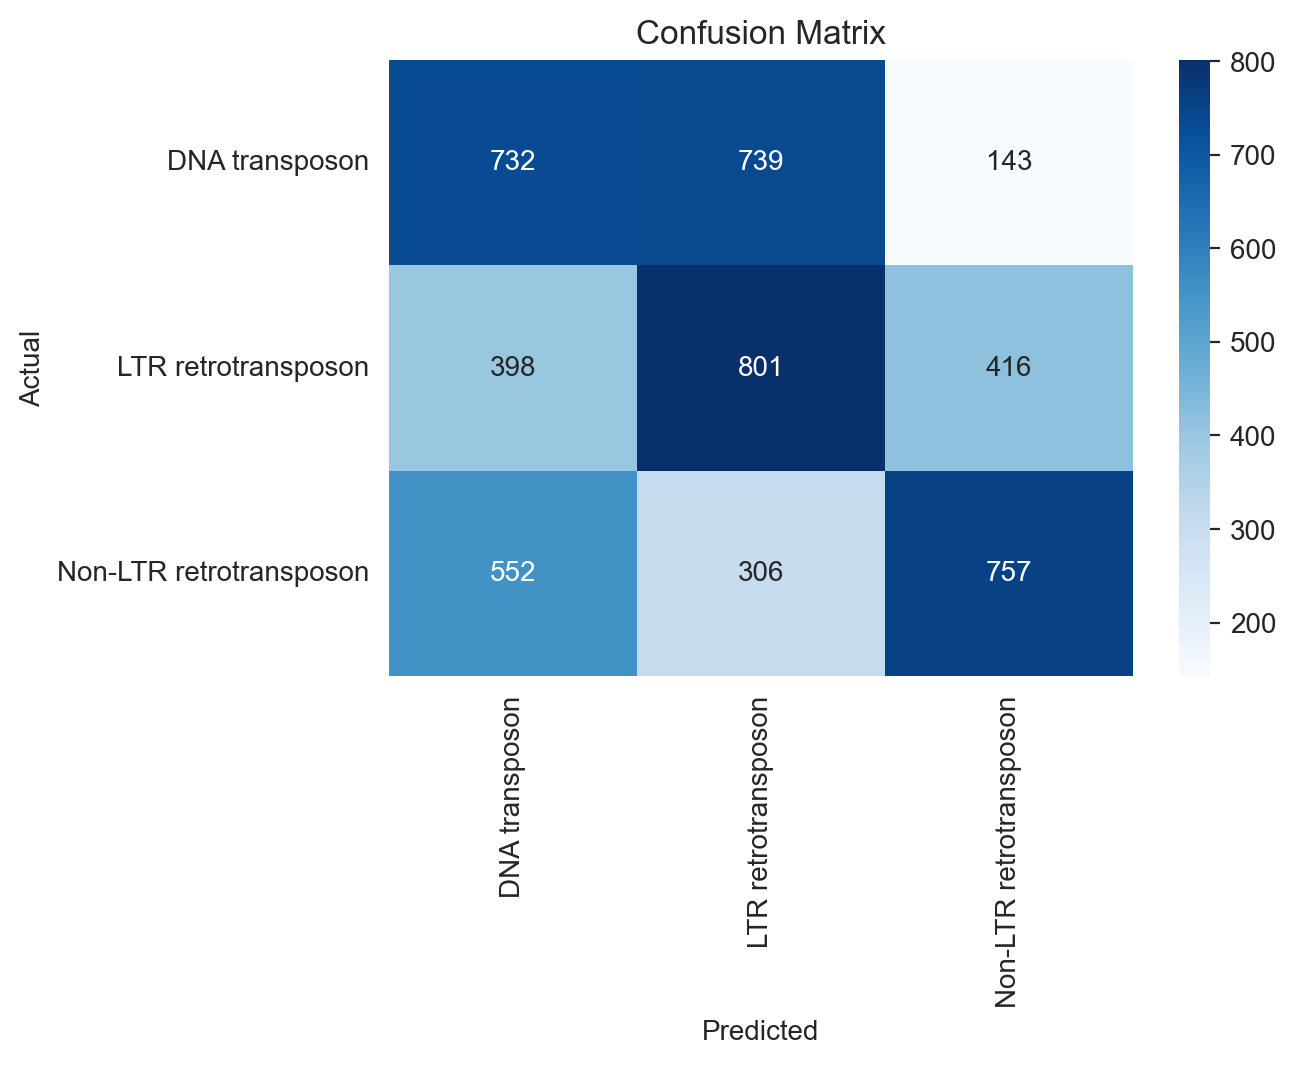

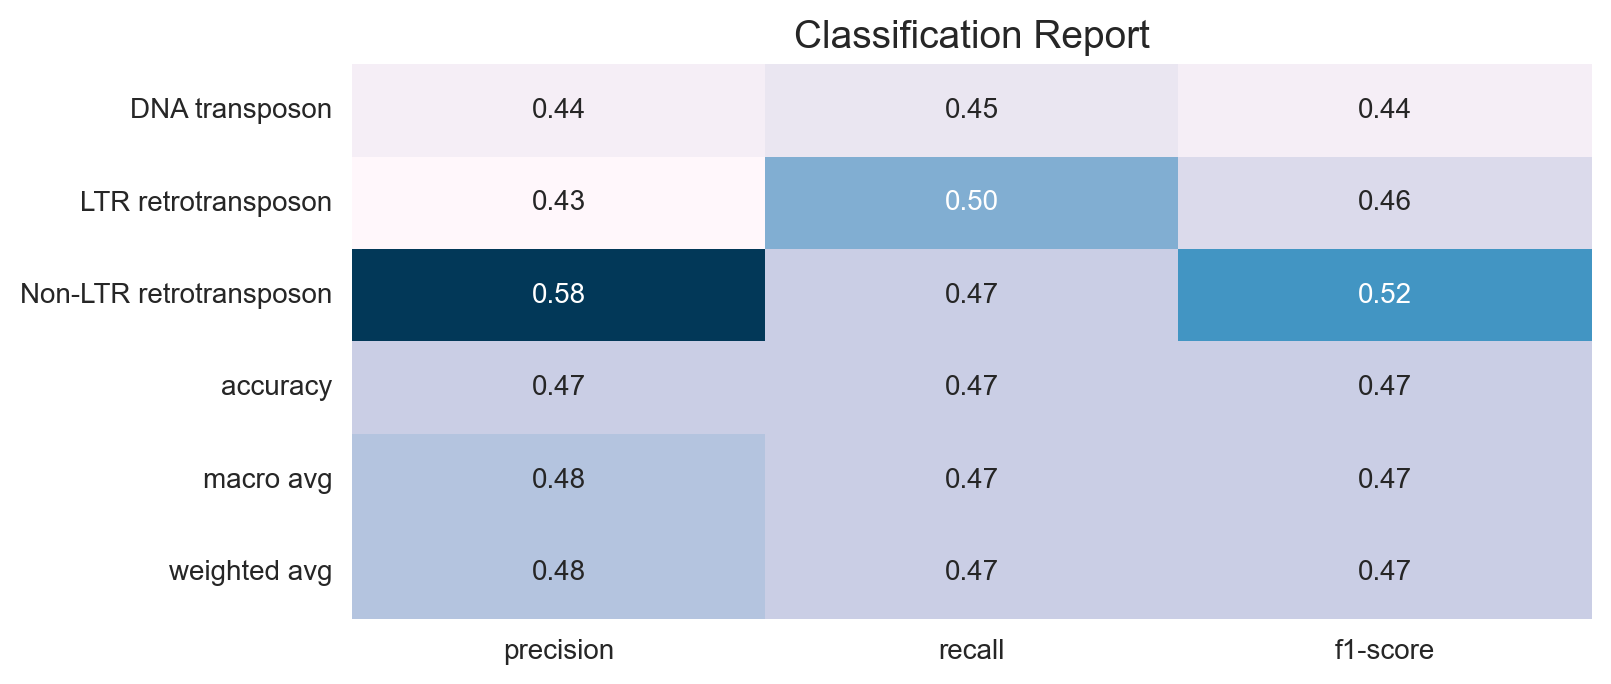

In [21]:
X = np.array([np.asarray(name_to_embedding[n], dtype=float).ravel() for n in names])
y_types = np.array([name_to_type[n] for n in names])

X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=1, random_state=42)
X_pca = pca.fit_transform(X_std)
X_pca

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=1,
    stratify=y
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

param_grid = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "solver": ["lbfgs"],
    "penalty": ["l2"],
    "multi_class": ["auto"],
    "class_weight": ["balanced"]
}

scoring = {
    "accuracy": "accuracy",
    "f1_macro": make_scorer(f1_score, average="macro")
}

gs = GridSearchCV(
    estimator=LogisticRegression(max_iter=2000),
    param_grid=param_grid,
    scoring=scoring,
    refit="f1_macro",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    verbose=0
)

gs.fit(X_train, y_train)

print("Лучшие параметры:", gs.best_params_)
print("Лучшая CV F1-macro:", gs.best_score_)

best_model = gs.best_estimator_

                         precision    recall  f1-score   support

         DNA transposon       0.44      0.45      0.44      1614
    LTR retrotransposon       0.43      0.50      0.46      1615
Non-LTR retrotransposon       0.58      0.47      0.52      1615

               accuracy                           0.47      4844
              macro avg       0.48      0.47      0.47      4844
           weighted avg       0.48      0.47      0.47      4844



In [23]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
class_names = sorted(list(set(y_test) | set(y_pred)))
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plot_classification_report(y_test, y_pred)

array([[  8.39687571],
       [  7.73442856],
       [  8.59788706],
       ...,
       [-12.28513926],
       [  5.15625694],
       [ 14.76439317]])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=1,
    stratify=y
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

param_grid = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "solver": ["lbfgs"],
    "penalty": ["l2"],
    "multi_class": ["auto"],
    "class_weight": ["balanced"]
}

scoring = {
    "accuracy": "accuracy",
    "f1_macro": make_scorer(f1_score, average="macro")
}

gs = GridSearchCV(
    estimator=LogisticRegression(max_iter=2000),
    param_grid=param_grid,
    scoring=scoring,
    refit="f1_macro",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    verbose=0
)

gs.fit(X_train, y_train)

print("Лучшие параметры:", gs.best_params_)
print("Лучшая CV F1-macro:", gs.best_score_)

best_model = gs.best_estimator_

Лучшие параметры: {'C': 1.0, 'class_weight': 'balanced', 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
Лучшая CV F1-macro: 0.38237667275795406


Accuracy: 0.4271263418662263


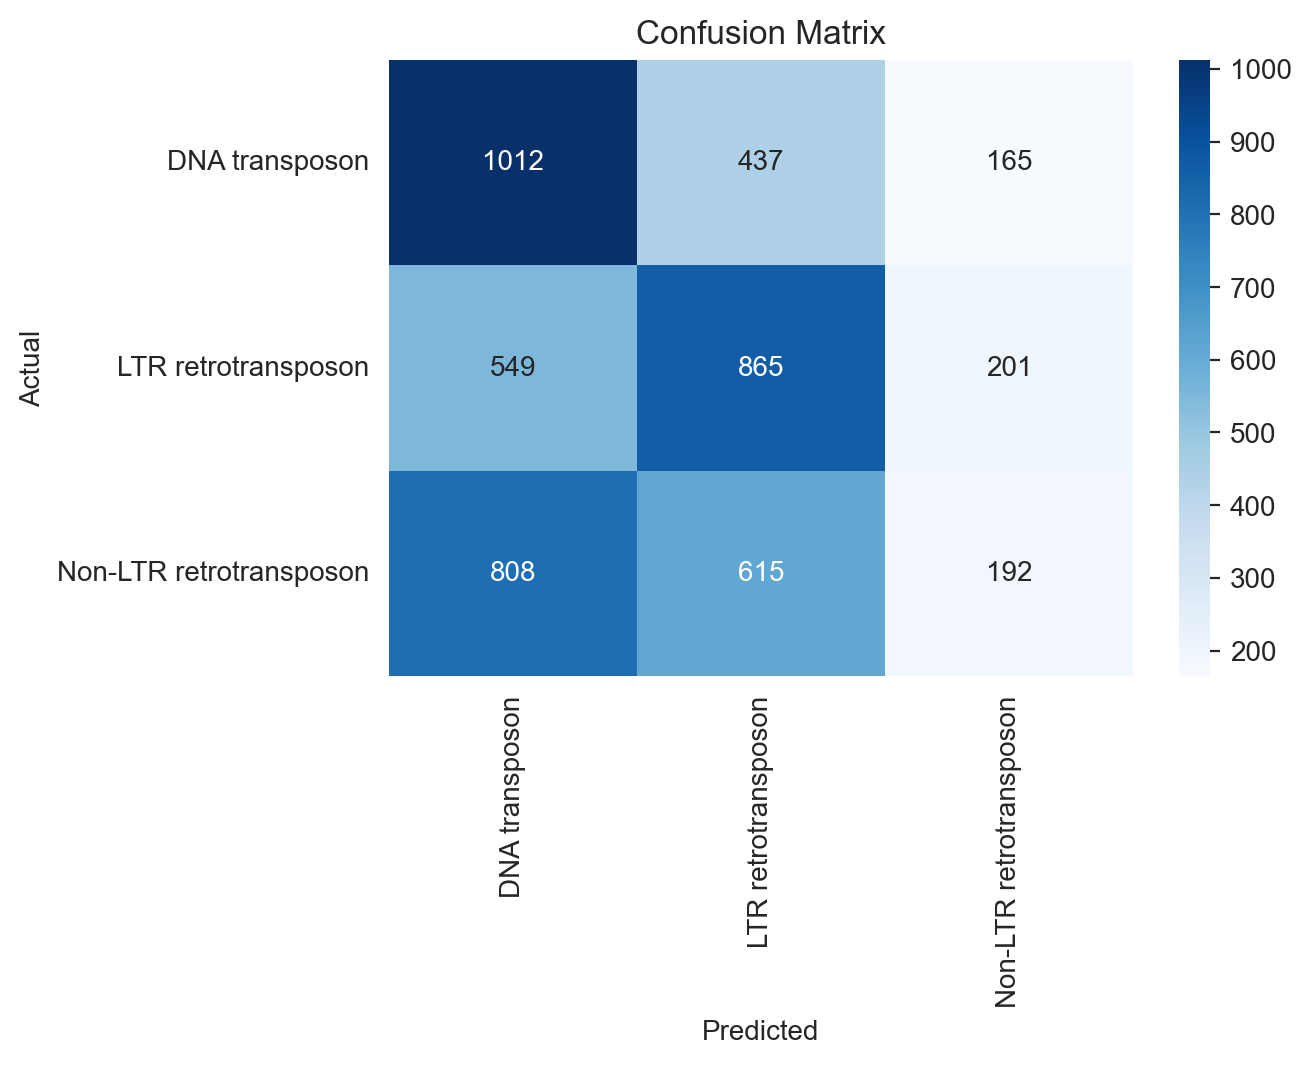

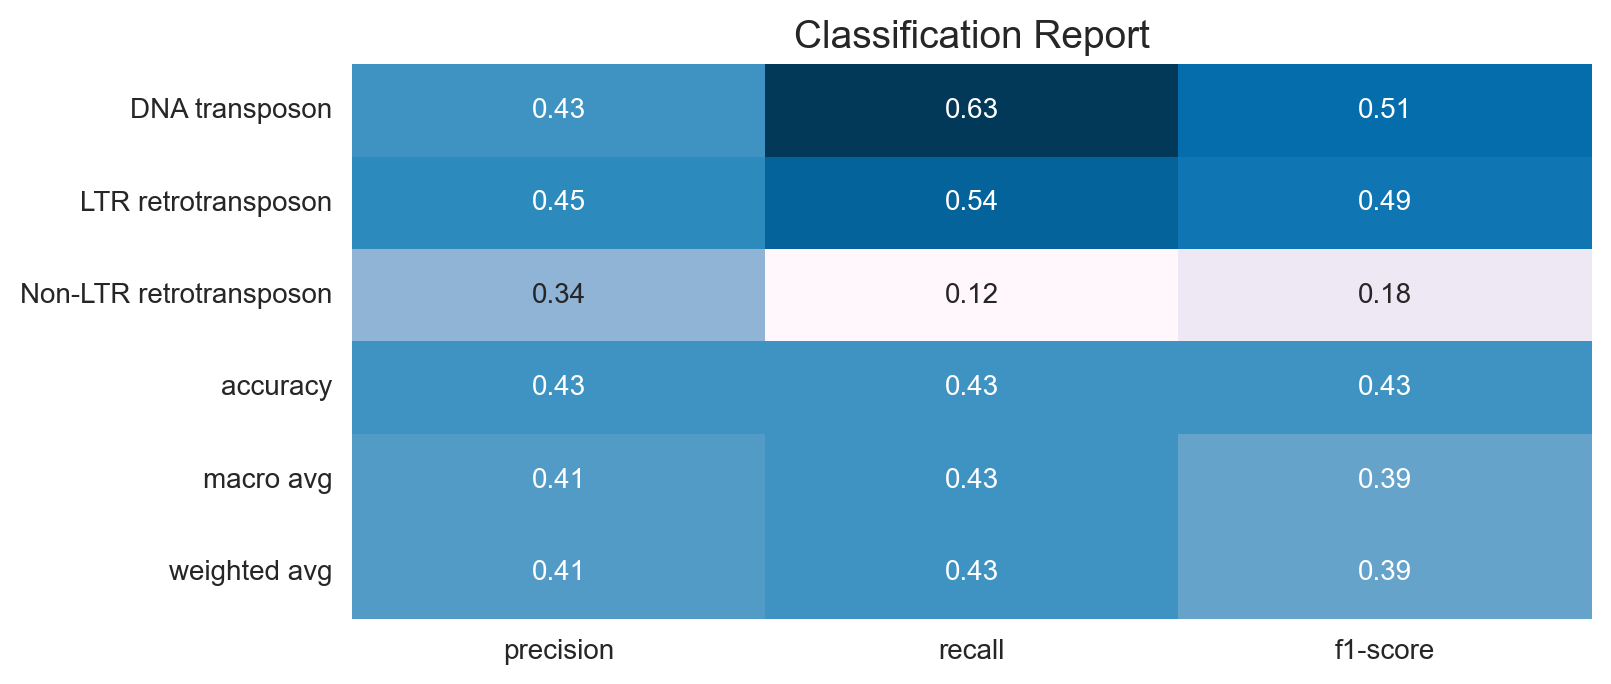

In [25]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
class_names = sorted(list(set(y_test) | set(y_pred)))
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plot_classification_report(y_test, y_pred)

# RandomForestClassifier

Accuracy: 0.7925268373245252


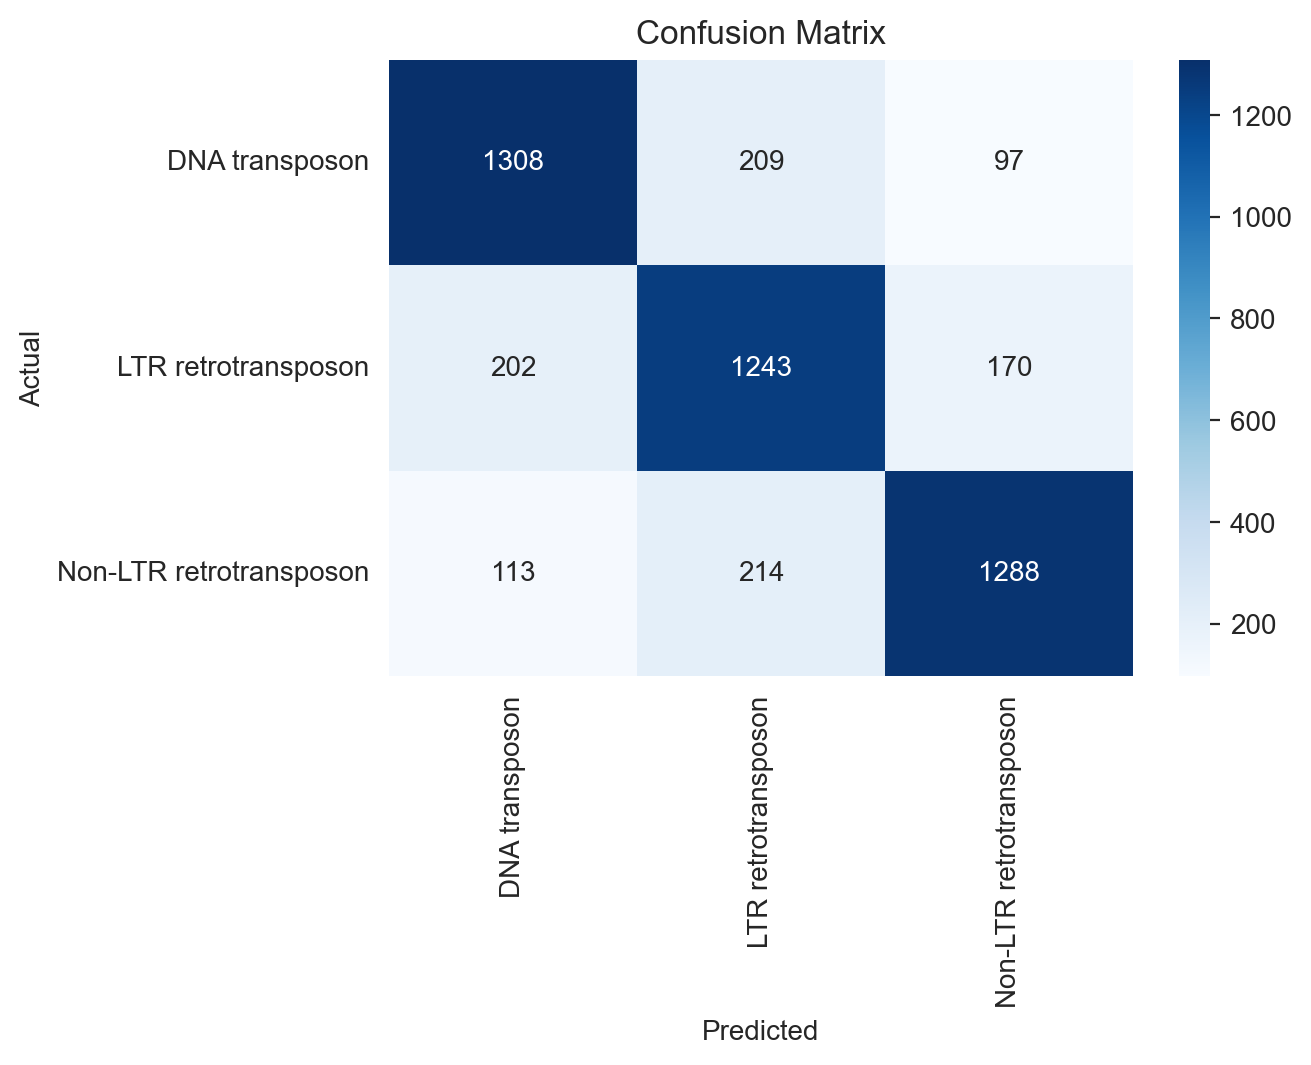

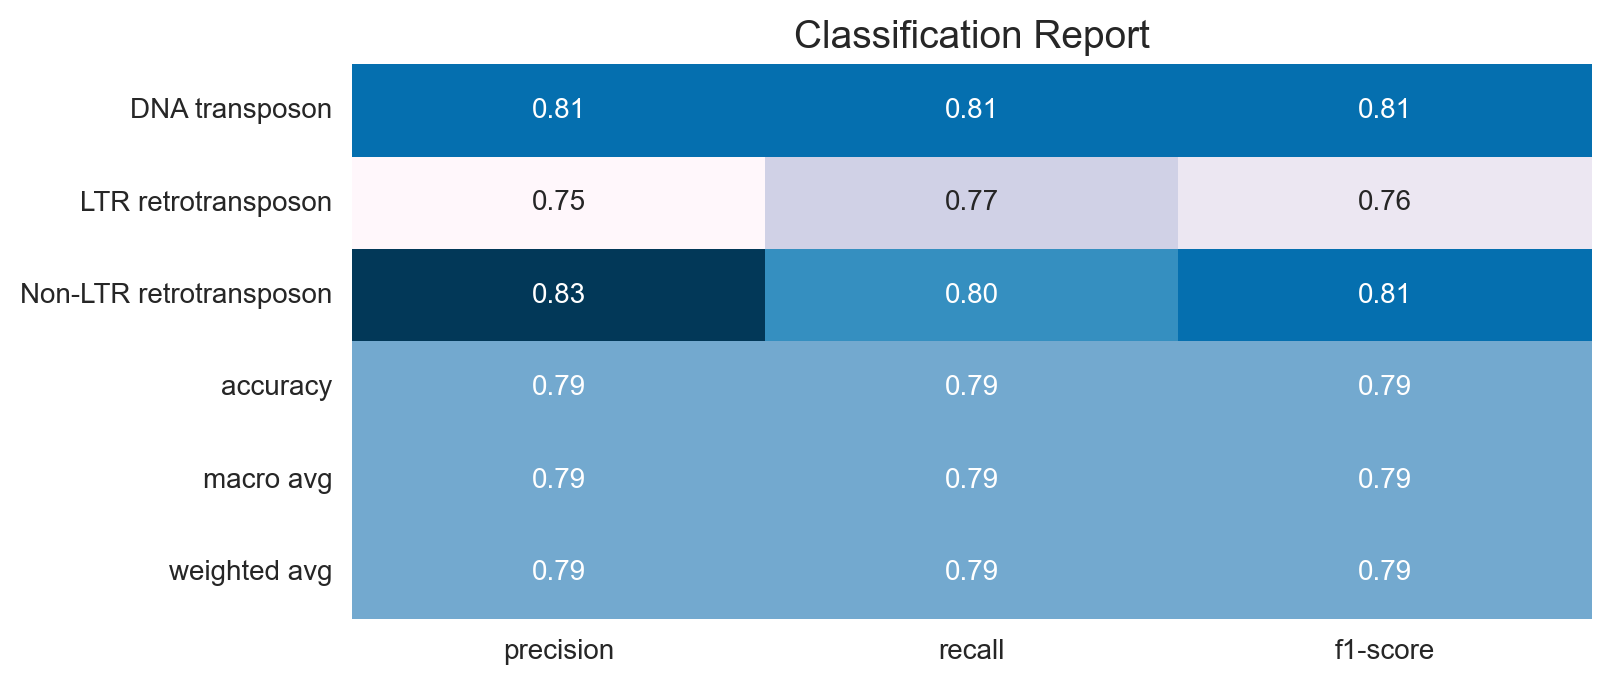

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

param_grid = {
    "n_estimators": [100, 200],         # число деревьев
    "max_depth": [None, 10, 20],         # глубина деревьев
    "min_samples_split": [2, 5, 10],         # минимальное число образцов для разбиения
    "min_samples_leaf": [2, 4],           # минимальное число образцов в листе
    "class_weight": ["balanced", None]       # балансировка классов
}

scoring = {
    "accuracy": "accuracy",
    "f1_macro": make_scorer(f1_score, average="macro")
}

# GridSearchCV
gs = GridSearchCV(
    estimator=RandomForestClassifier(random_state=1, n_jobs=-1),
    param_grid=param_grid,
    scoring=scoring,
    refit="f1_macro",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)


gs.fit(X_train, y_train)

print("Лучшие параметры:", gs.best_params_)
print("Лучшая CV F1-macro:", gs.best_score_)

best_model = gs.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
class_names = sorted(list(set(y_test) | set(y_pred)))
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plot_classification_report(y_test, y_pred)

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

param_grid = {
    "n_estimators": [100, 200],         # число деревьев
    "max_depth": [None, 10, 20],         # глубина деревьев
    "min_samples_split": [2, 5, 10],         # минимальное число образцов для разбиения
    "min_samples_leaf": [2, 4],           # минимальное число образцов в листе
    "class_weight": ["balanced", None]       # балансировка классов
}

scoring = {
    "accuracy": "accuracy",
    "f1_macro": make_scorer(f1_score, average="macro")
}

# GridSearchCV
gs = GridSearchCV(
    estimator=RandomForestClassifier(random_state=1, n_jobs=-1),
    param_grid=param_grid,
    scoring=scoring,
    refit="f1_macro",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)


gs.fit(X_train, y_train)

print("Лучшие параметры:", gs.best_params_)
print("Лучшая CV F1-macro:", gs.best_score_)

best_model = gs.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

Accuracy: 0.5169281585466556


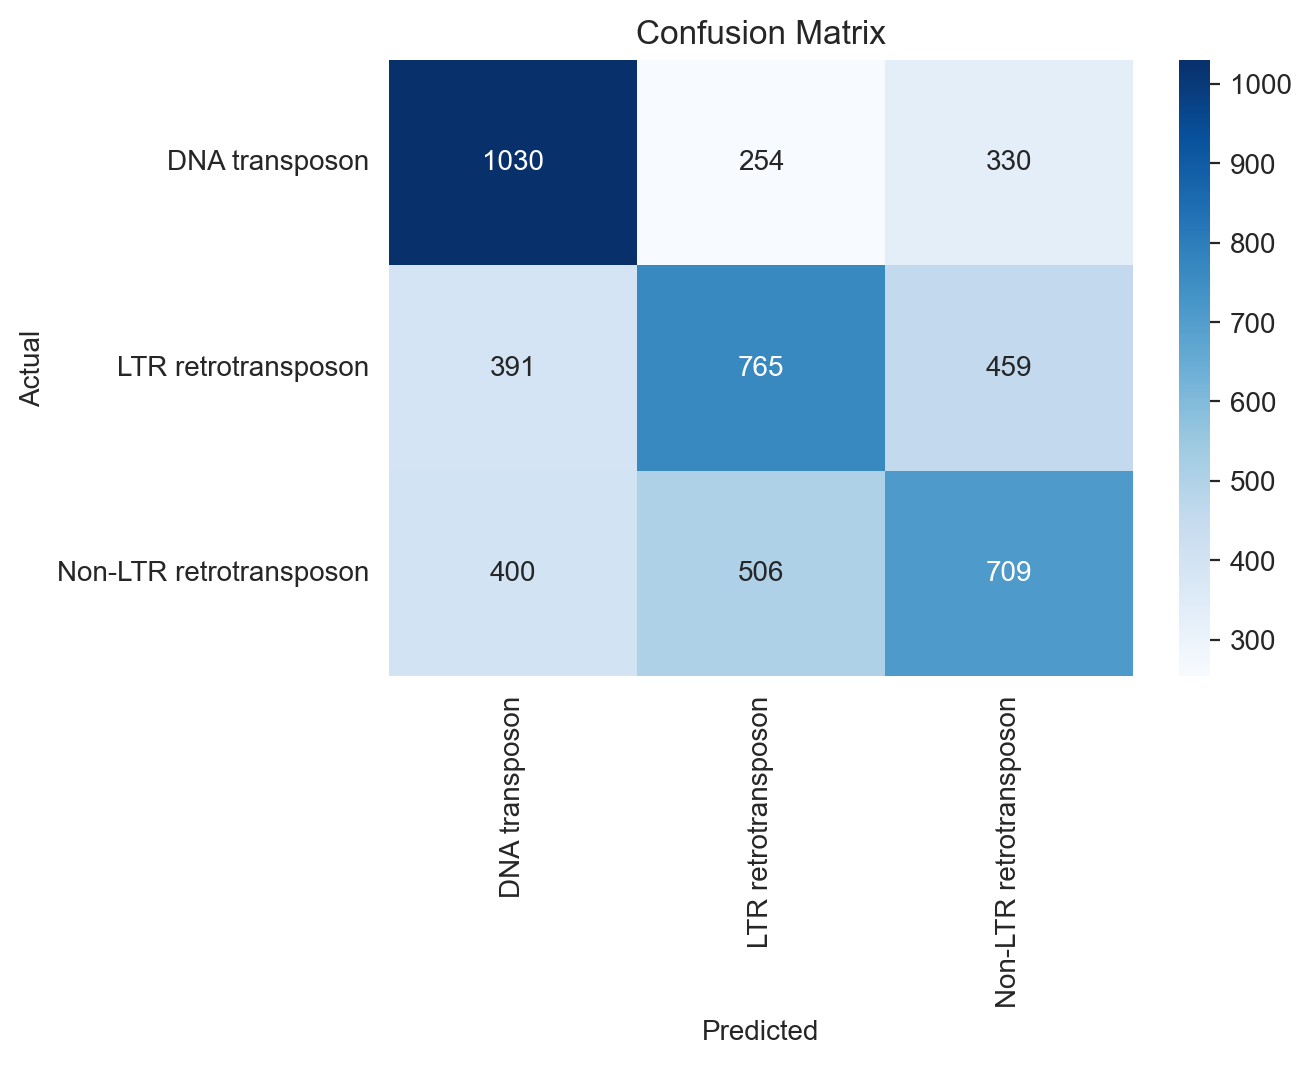

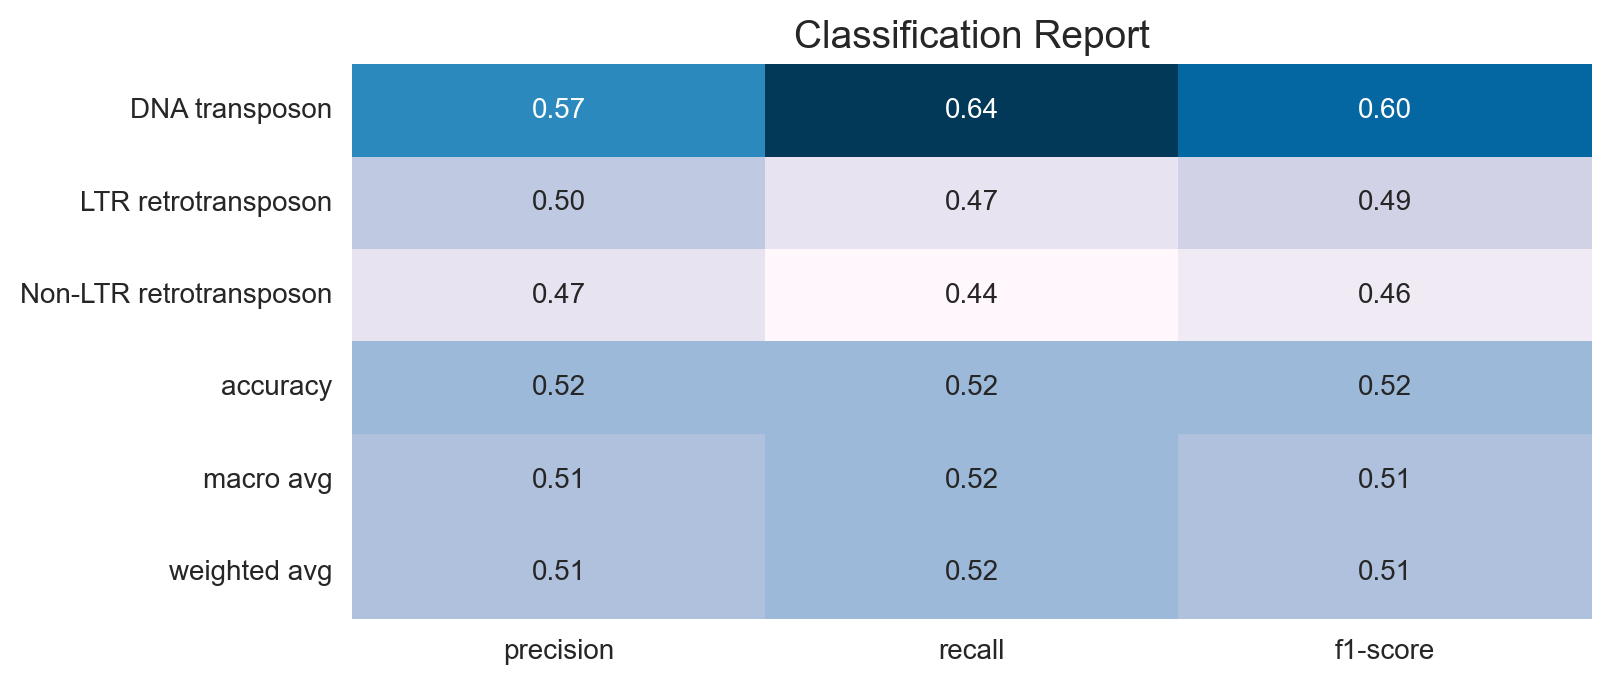

In [27]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
class_names = sorted(list(set(y_test) | set(y_pred)))
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plot_classification_report(y_test, y_pred)